# Imports and TB

In [4]:
# !pip install --quiet -U bigartm pymorphy2[fast] pyLDAvis

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
samplesizelib 0.0.4 requires numpy==1.18.5, but you have numpy 1.22.3 which is incompatible.
pymatgen 2022.0.8 requires scipy>=1.5.0, but you have scipy 1.3.3 which is incompatible.


In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import gridspec

from tqdm.notebook import tqdm
import numpy as np
import  pandas as pd
import seaborn as sns
import pymorphy2
import torch
import scipy
from sklearn.utils import shuffle
import re

import artm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from torch.utils.tensorboard import SummaryWriter

from xgboost import XGBClassifier

from pathlib import Path


/home/serg/miniconda3/lib/python3.8/site-packages/sklearn/feature_extraction/image.py:172: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
/home/serg/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: 

In [3]:
# from google.colab import drive
# from pathlib import Path
# drive.mount('/content/drive', force_remount=True)

WORKDIR = Path('./')

In [4]:
TB_DIR = WORKDIR / "tensorboard"
DATA_DIR = WORKDIR / "data"

# 1. Data
Используем предобработанную выборку из семинара 19.

In [5]:
processed_data = pd.read_csv(DATA_DIR / 'lenta-ru-proccess.csv')

In [5]:
processed_data

,text,tags,len,date
0,1 сентябрь весь территория россия вводиться но...,Все,1654,31-08-1999
1,"сведение миссия оон , передаваемый риа "" новос...",Все,1086,31-08-1999
2,15 представитель национал - большевистский пар...,Все,1219,31-08-1999
3,наметить сегодняшний день церемония вступление...,Все,3094,31-08-1999
4,"юг киргизия , именно баткенский чон - алайском...",Все,1354,31-08-1999
...,...,...,...,...
863280,популярный место среди турист мурманский облас...,Россия,1231,11-09-2020
863281,рейтинг международный рейтинговый агентство s ...,NaN,1425,11-09-2020
863282,российский учёный найти якутия новый подвид ар...,События,1299,11-09-2020
863283,указание коронавирус причина смерть человек не...,Общество,2061,11-09-2020


## 1.2 Split via modalities
Так как bigartm будет учиться на каждом наборе модальностей отдельно, то необходимо создать три соответствующих vowpal_wabbit файла. Опять же, делаем это по аналогии с семинаром 19. Будем анализировать три набора модальностей:
- Только текст
- Текст и тег
- Текст, тег и месяц 

Также у нас будет ещё одна дополнительная модальность -- год. Она будет использована лишь в самом конце -- для предсказания даты средствами самого BigARTM, без использования дополнительных классификаторов.

In [6]:
# PATHS
filename_valid_clear = DATA_DIR / 'vw_data/texts_valid_clear.vw.txt'
filename_train_clear = DATA_DIR / 'vw_data/texts_train_clear.vw.txt'

filename_valid_tag = DATA_DIR / 'vw_data/texts_valid_tag.vw.txt'
filename_train_tag = DATA_DIR / 'vw_data/texts_train_tag.vw.txt'

filename_valid_tag_month = DATA_DIR / 'vw_data/texts_valid_tag_month.vw.txt'
filename_train_tag_month = DATA_DIR / 'vw_data/texts_train_tag_month.vw.txt'

filename_valid_tag_month_year = DATA_DIR / 'vw_data/texts_valid_tag_month_year.vw.txt'
filename_train_tag_month_year = DATA_DIR / 'vw_data/texts_train_tag_month_year.vw.txt'

filename_y_train = DATA_DIR / "vw_data/y_train.txt"
filename_y_valid = DATA_DIR / "vw_data/y_valid.txt"

In [8]:
# NO MODALITY

counter_train = 0
counter_valid = 0

y_train = []
y_valid = []

reg = re.compile(r'\W+')
with open(filename_valid_clear, 'w') as fout_valid:
    with open(filename_train_clear, 'w') as fout_train:
        for i in tqdm(range(len(processed_data))):
            text = (reg.sub(' ', processed_data.loc[i]['text']).strip()).split()
            date = str(processed_data.loc[i]['date'].split('-')[-1])

            if len(text) > 100:
                if (i + 1) % 100 == 0:
                    fout_valid.write('doc_{} {} \n'.format(
                        counter_train, ' '.join(text)))
                    counter_train += 1
                    y_valid.append(date)
                else:
                    fout_train.write('doc_{} {} \n'.format(
                        counter_valid, ' '.join(text)))
                    counter_valid += 1
                    y_train.append(date)

In [9]:
# y_train and y_valid remains the same for all cases

with open(filename_y_train, "w") as f:
    f.write("\n".join(y_train))

with open(filename_y_valid, "w") as f:
    f.write("\n".join(y_valid))

In [10]:
# TAG
counter_train = 0
counter_valid = 0

reg = re.compile(r'\W+')
with open(filename_valid_tag, 'w') as fout_valid:
    with open(filename_train_tag, 'w') as fout_train:
        for i in tqdm(range(len(processed_data))):
            text = (reg.sub(' ', processed_data.loc[i]['text']).strip()).split()
            tag = str(processed_data.loc[i]['tags']).lower().strip()

            if len(text) > 100:
                if (i + 1) % 100 == 0:
                    fout_valid.write('doc_{} {} |@tag class_{}\n'.format(
                        counter_train, ' '.join(text), tag))
                    counter_train += 1
                else:
                    fout_train.write('doc_{} {} |@tag class_{}\n'.format(
                        counter_valid, ' '.join(text), tag))
                    counter_valid += 1

In [11]:
# TAG + MONTH
counter_train = 0
counter_valid = 0


reg = re.compile(r'\W+')
with open(filename_valid_tag_month, 'w') as fout_valid:
    with open(filename_train_tag_month, 'w') as fout_train:
        for i in tqdm(range(len(processed_data))):
            text = (reg.sub(' ', processed_data.loc[i]['text']).strip()).split()
            tag = str(processed_data.loc[i]['tags']).lower().strip()
            month = int(str(processed_data.loc[i]['date']).split('-')[1])

            if len(text) > 100:
                if (i + 1) % 100 == 0:
                    fout_valid.write('doc_{} {} |@tag class_{} |@month class_{}\n'.format(
                        counter_train, ' '.join(text), tag, month))
                    counter_train += 1
                else:
                    fout_train.write('doc_{} {} |@tag class_{} |@month class_{}\n'.format(
                        counter_valid, ' '.join(text), tag, month))
                    counter_valid += 1

In [7]:
# TAG + MONTH + YEAR
counter_train = 0
counter_valid = 0


reg = re.compile(r'\W+')
with open(filename_valid_tag_month_year, 'w') as fout_valid:
    with open(filename_train_tag_month_year, 'w') as fout_train:
        for i in tqdm(range(len(processed_data))):
            text = (reg.sub(' ', processed_data.loc[i]['text']).strip()).split()
            tag = str(processed_data.loc[i]['tags']).lower().strip()
            month = int(str(processed_data.loc[i]['date']).split('-')[1])
            year = int(str(processed_data.loc[i]['date']).split('-')[-1])

            if len(text) > 100:
                if (i + 1) % 100 == 0:
                    fout_valid.write('doc_{} {} |@tag class_{} |@month class_{} |@year class_{}\n'.format(
                        counter_train, ' '.join(text), tag, month, year))
                    counter_train += 1
                else:
                    fout_train.write('doc_{} {} |@tag class_{} |@month class_{} |@year class_{}\n'.format(
                        counter_valid, ' '.join(text), tag, month, year))
                    counter_valid += 1

## 1.3 Generate batches

In [2]:
# NO MODALITY

# to create
# bv_train_clear = artm.BatchVectorizer(
#     data_path=str(filename_train_clear), data_format='vowpal_wabbit', batch_size=10000, 
#     target_folder="data/vw_batches/batches_train_clear", )

# bv_test_clear = artm.BatchVectorizer(
#     data_path=str(filename_valid_clear), data_format='vowpal_wabbit', batch_size=10000, 
#     target_folder="data/vw_batches/batches_valid_clear")

# just load
bv_train_clear = artm.BatchVectorizer(data_path='data/vw_batches/batches_train_clear',
                                        data_format='batches')

bv_test_clear = artm.BatchVectorizer(data_path="data/vw_batches/batches_valid_clear", data_format='batches')

In [2]:
# TAG

# to create
# bv_train_tag = artm.BatchVectorizer(
#     data_path=str(filename_train_tag), data_format='vowpal_wabbit', batch_size=10000, 
#     target_folder="data/vw_batches/batches_train_tag", )

# bv_test_tag = artm.BatchVectorizer(
#     data_path=str(filename_valid_tag), data_format='vowpal_wabbit', batch_size=10000, 
#     target_folder="data/vw_batches/batches_valid_tag")

# just load
bv_train_tag = artm.BatchVectorizer(data_path='data/vw_batches/batches_train_tag/',
                                        data_format='batches')

bv_test_tag = artm.BatchVectorizer(data_path="data/vw_batches/batches_valid_tag/", data_format='batches')

In [2]:
# TAG + MONTH
# bv_train_tag_month = artm.BatchVectorizer(
#     data_path=str(filename_train_tag_month), data_format='vowpal_wabbit', batch_size=10000, 
#     target_folder="data/vw_batches/batches_train_tag_month")

# bv_test_tag_month = artm.BatchVectorizer(
#     data_path=str(filename_valid_tag_month), data_format='vowpal_wabbit', batch_size=10000, 
#     target_folder="data/vw_batches/batches_valid_tag_month")

# just load

bv_train_tag_month = artm.BatchVectorizer(data_path='data/vw_batches/batches_train_tag_month/',
                                        data_format='batches')

bv_test_tag_month = artm.BatchVectorizer(data_path="data/vw_batches/batches_valid_tag_month/", data_format='batches')

In [9]:
# TAG + MONTH + YEAR
# bv_train_tag_month_year = artm.BatchVectorizer(
#     data_path=str(filename_train_tag_month_year), data_format='vowpal_wabbit', batch_size=10000, 
#     target_folder="data/vw_batches/batches_train_tag_month_year")

# bv_test_tag_month_year = artm.BatchVectorizer(
#     data_path=str(filename_valid_tag_month_year), data_format='vowpal_wabbit', batch_size=10000, 
#     target_folder="data/vw_batches/batches_valid_tag_month_year")

# just load

bv_train_tag_month_year  = artm.BatchVectorizer(data_path='data/vw_batches/batches_train_tag_month_year/',
                                        data_format='batches')

bv_test_tag_month_year  = artm.BatchVectorizer(data_path="data/vw_batches/batches_valid_tag_month_year/", data_format='batches')

# 2. Experiment
Так как в данном задании не предполагается реализация какого-либо функционала, то можно перейти сразу к экспериментам. Модели тяжелые, а количество возможых вариантов тех же регуляризаторов большое, потому будем действовать следующим образом: 
1. Сначала проверим, как модели работает на выборках с различными модальностями.
2. Отобрав из них лучшую (скорее всего, это будет последняя), будет тестировать уже регуляризаторы.


## 2.1 Use pure text

In [8]:
dictionary = artm.Dictionary()
dictionary.gather(data_path='data/vw_batches/batches_train_clear')

In [9]:
# model = artm.ARTM(num_topics=200,
#                   dictionary=dictionary, 
#                   class_ids={'@default_class': 1.0}, num_processors=11)

# model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))
# model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))

# iterator = tqdm(range(20))
# for i in iterator:
#     model.fit_offline(bv_train_clear, num_collection_passes=1)
#     iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1], })

# model.dump_artm_model('data/model/clear_without_regular_20')

model = artm.load_artm_model('data/model/clear_without_regular/')
model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary), overwrite=True)
model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10), overwrite=True)

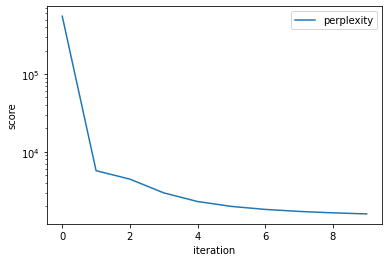

In [10]:
plt.plot(model.score_tracker['perplexity'].value, label = 'perplexity')

plt.legend(loc = 'best')

plt.xlabel('iteration')
plt.ylabel('score')
plt.yscale("log")
plt.show()


In [11]:
top_tokens = model.score_tracker['top-tokens'].last_tokens

for topic_name in model.topic_names[:20]:
    print(top_tokens[topic_name])

['учёный', 'исследование', 'исследователь', 'который', 'это', 'клетка', 'анализ', 'человек', 'результат', 'мочь']
['английский', 'реал', 'барселона', 'англия', 'клуб', 'манчестер', 'челси', 'футболист', 'лондонский', 'испанский']
['германия', 'немецкий', 'который', 'фрг', 'свой', 'еда', 'канцлер', 'меркель', 'ангел', 'кот']
['министерство', 'база', 'конференция', 'зона', 'предложение', 'создание', 'который', 'инициатива', 'ведомство', 'российский']
['документ', 'срок', 'запрет', 'принять', 'правительство', 'введение', 'решение', 'должный', 'год', 'ввести']
['россия', 'российский', 'мид', 'наш', 'это', 'москва', 'заявить', 'рф', 'украина', 'страна']
['министр', 'внутренний', 'анатолий', 'ведомство', 'дело', 'оборона', 'минобороны', 'подпись', 'глава', 'который']
['деятельность', 'государственный', 'контроль', 'журналист', 'служба', 'власть', 'паспорт', 'сми', 'это', 'год']
['директор', 'генеральный', 'аэрофлот', 'год', 'вино', 'культура', 'который', 'новосибирский', 'гендиректор', 'росс

In [12]:
X_train_pd = model.transform(bv_train_clear)

In [13]:
X_train_pd.shape

(200, 653795)

In [14]:
with open('data/vw_data/y_valid.txt') as f:
    y_valid = f.read().split('\n')

with open('data/vw_data/y_train.txt') as f:
    y_train = f.read().split('\n')

In [15]:
X_train = []
for i in tqdm(range(len(y_train))):
    X_train.append(X_train_pd[i].values)
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)

X_train_np, y_train_np = shuffle(X_train_np, y_train_np,random_state=42)

In [16]:
X_valid_pd = model.transform(bv_test_clear)
X_valid = []
for i in tqdm(range(len(y_valid))):
    X_valid.append(X_valid_pd[i].values)
    
X_valid_np = np.array(X_valid)

In [18]:
classifier = XGBClassifier(n_jobs=-1)
classifier.fit(X_train_np[:10000], y_train_np[:10000])
pred = classifier.predict(X_valid_np)
print(classification_report(y_valid, pred, zero_division=1))

/home/serg/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:29:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

        1999       0.00      0.00      0.00        19
        2000       0.00      0.00      0.00        69
        2001       0.08      0.01      0.02        96
        2002       0.17      0.02      0.04       143
        2003       0.17      0.03      0.05       134
        2004       0.20      0.09      0.12       183
        2005       0.12      0.07      0.08       240
        2006       0.13      0.08      0.10       256
        2007       0.09      0.03      0.05       236
        2008       0.14      0.17      0.15       332
        2009       0.14      0.17      0.15       423
        2010       0.12      0.14      0.13       375
        2011       0.18      0.18      0.18 

**Вывод:** качество классификации небольшое, то же accuracy получилось 0.19. Однако, это значительно больше, чем просто использование случайного классификатора, его качество было бы около 5%. С другой стороны, по содержанию самой новости не всегда понятно, к какой она дате может относится. Пример такой новости -- развод очередной "звездной" пары, они происходят регулярно каждый год. Потому в целом такие невысокие метрики обусловлены не тем, что модель плохая, а спецификой задачи. 

## 2.2 Text + tag

In [5]:
# dictionary = artm.Dictionary()
# dictionary.gather(data_path='data/vw_batches/batches_train_tag/')

# model = artm.ARTM(num_topics=200,
#                   dictionary=dictionary, 
#                   class_ids={'@default_class': 1.0, '@tag': 1.0}, num_processors=12)

# model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))
# model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))
# model.scores.add(artm.SparsityPhiScore(name='sparsity', class_id='@tag'))


# iterator = tqdm(range(20))
# for i in iterator:
#     model.fit_offline(bv_train_tag, num_collection_passes=1)
#     iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1], })

# model.dump_artm_model('data/model/tag_without_regular')

model = artm.load_artm_model('data/model/tag_without_regular/')
model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary), overwrite=True)
model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10), overwrite=True)
model.scores.add(artm.SparsityPhiScore(name='sparsity', class_id='@tag'), overwrite=True)

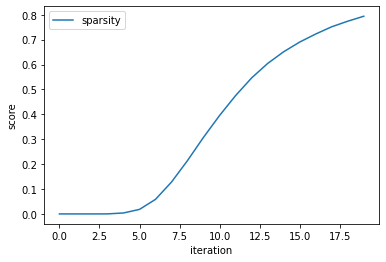

In [6]:
plt.plot(model.score_tracker['sparsity'].value, label = 'sparsity')

plt.legend(loc = 'best')

plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

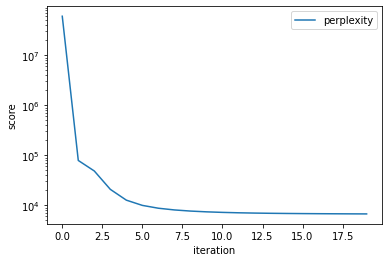

In [7]:
plt.plot(model.score_tracker['perplexity'].value, label = 'perplexity')

plt.legend(loc = 'best')

plt.xlabel('iteration')
plt.ylabel('score')
plt.yscale("log")
plt.show()

In [8]:
X_train_pd = model.transform(bv_train_tag)

with open('data/vw_data/y_valid.txt') as f:
    y_valid = f.read().split('\n')

with open('data/vw_data/y_train.txt') as f:
    y_train = f.read().split('\n')

X_train = []
for i in tqdm(range(len(y_train))):
    X_train.append(X_train_pd[i].values)
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)

X_train_np, y_train_np = shuffle(X_train_np, y_train_np,random_state=42)

X_valid_pd = model.transform(bv_test_tag)
X_valid = []
for i in tqdm(range(len(y_valid))):
    X_valid.append(X_valid_pd[i].values)
    
X_valid_np = np.array(X_valid)

In [9]:
classifier = XGBClassifier(n_jobs=-1)
classifier.fit(X_train_np[:10000], y_train_np[:10000])
pred = classifier.predict(X_valid_np)
print(classification_report(y_valid, pred, zero_division=1))

/home/serg/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:50:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

        1999       1.00      0.00      0.00        19
        2000       0.00      0.00      0.00        69
        2001       0.15      0.02      0.04        96
        2002       0.12      0.03      0.05       143
        2003       0.17      0.04      0.07       134
        2004       0.13      0.05      0.08       183
        2005       0.13      0.08      0.10       240
        2006       0.15      0.10      0.12       256
        2007       0.11      0.05      0.07       236
        2008       0.13      0.15      0.14       332
        2009       0.14      0.22      0.17       423
        2010       0.12      0.15      0.13       375
        2011       0.17      0.19      0.18 

**Вывод:** качество по сравнению с предыдущей моделью возросло не сильно, однако росто наблюдается во всех метриках. Это говорит о благотворном влиянии дополнительной модальности на результат.

## 2.3 Text + tag + month

In [ ]:
dictionary = artm.Dictionary()
dictionary.gather(data_path='data/vw_batches/batches_train_tag_month/')

model = artm.ARTM(num_topics=200,
                  dictionary=dictionary, 
                  class_ids={'@default_class': 1.0, '@tag': 10.0, '@month': 10.0}, num_processors=12)

model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))
model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))
model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'))
model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'))



iterator = tqdm(range(20))
for i in iterator:
    model.fit_offline(bv_train_tag_month, num_collection_passes=1)
    iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1], })

model.dump_artm_model('data/model/tag_month_without_regular')

# model = artm.load_artm_model('data/model/tag_month_without_regular/')
# model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary), overwrite=True)
# model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10), overwrite=True)
# model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'), overwrite=True)
# model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'), overwrite=True)

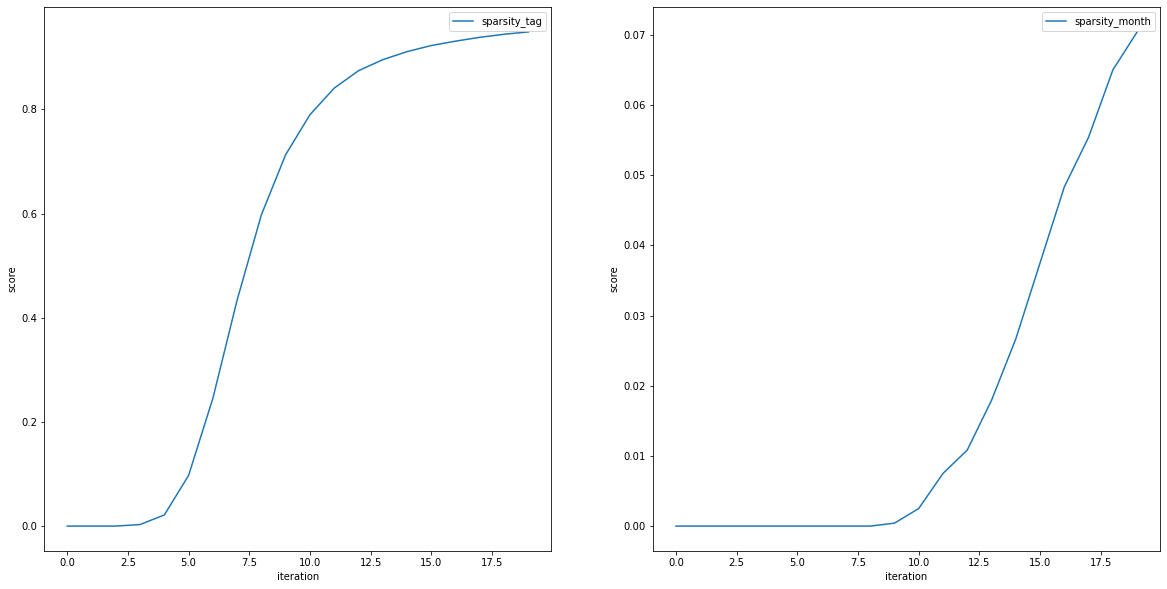

In [5]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(model.score_tracker['sparsity_tag'].value, label = 'sparsity_tag')

plt.legend(loc = 'best')

plt.xlabel('iteration')
plt.ylabel('score')


plt.subplot(1, 2, 2)
plt.plot(model.score_tracker['sparsity_month'].value, label = 'sparsity_month')

plt.legend(loc = 'best')

plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

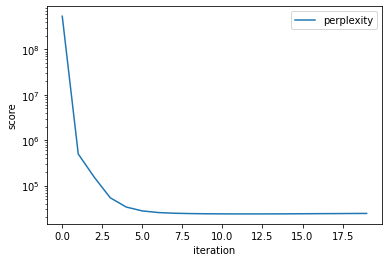

In [6]:
plt.plot(model.score_tracker['perplexity'].value, label = 'perplexity')

plt.legend(loc = 'best')

plt.xlabel('iteration')
plt.ylabel('score')
plt.yscale("log")
plt.show()

In [7]:
X_train_pd = model.transform(bv_train_tag_month)

with open('data/vw_data/y_valid.txt') as f:
    y_valid = f.read().split('\n')

with open('data/vw_data/y_train.txt') as f:
    y_train = f.read().split('\n')

X_train = []
for i in tqdm(range(len(y_train))):
    X_train.append(X_train_pd[i].values)
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)

X_train_np, y_train_np = shuffle(X_train_np, y_train_np,random_state=42)

X_valid_pd = model.transform(bv_test_tag_month)
X_valid = []
for i in tqdm(range(len(y_valid))):
    X_valid.append(X_valid_pd[i].values)
    
X_valid_np = np.array(X_valid)

In [8]:
classifier = XGBClassifier(n_jobs=-1)
classifier.fit(X_train_np[:10000], y_train_np[:10000])
pred = classifier.predict(X_valid_np)
print(classification_report(y_valid, pred, zero_division=1))

/home/serg/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:49:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

        1999       1.00      0.00      0.00        19
        2000       0.14      0.01      0.03        69
        2001       0.25      0.05      0.09        96
        2002       0.31      0.06      0.09       143
        2003       0.22      0.06      0.09       134
        2004       0.21      0.13      0.16       183
        2005       0.17      0.17      0.17       240
        2006       0.12      0.10      0.11       256
        2007       0.10      0.05      0.07       236
        2008       0.19      0.22      0.20       332
        2009       0.22      0.35      0.27       423
        2010       0.18      0.26      0.21       375
        2011       0.20      0.19      0.19 

**Вывод:** качество существенно возросло по всем показателям, примерно на 5% в каждом. Тут, однако, стоит отметить, что помимо введения дополнительной модальности месяца были увеличены веса модельностей @tag и @month. Это было необходимо, т.к. sparsity у month не увеличивалось, а у @tag росло медленно при единичных весах.

## 2.4 Text + tag + month, decorrelation regularizer

In [3]:
# dictionary = artm.Dictionary()
# dictionary.gather(data_path='data/vw_batches/batches_train_tag_month/')

# model = artm.ARTM(num_topics=250,
#                   dictionary=dictionary, 
#                   class_ids={'@default_class': 1.0, '@tag': 10.0, '@month': 10.0}, num_processors=12)

# model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))
# model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))
# model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'))
# model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'))

# model.regularizers.add(artm.DecorrelatorPhiRegularizer("decor", tau=1e+5))

# iterator = tqdm(range(20))
# for i in iterator:
#     model.fit_offline(bv_train_tag_month, num_collection_passes=1)
#     iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1], })

# model.dump_artm_model("data/model/tag_month_decor/")

model = artm.load_artm_model('data/model/tag_month_decor/')
model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary), overwrite=True)
model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10), overwrite=True)
model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'), overwrite=True)
model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'), overwrite=True)

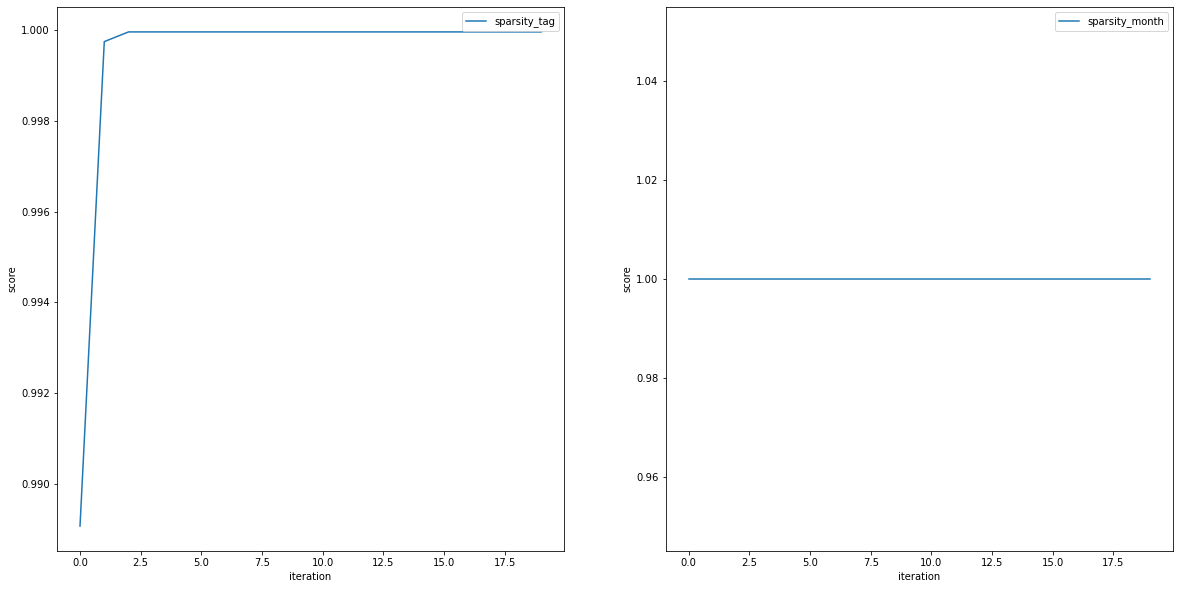

In [4]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(model.score_tracker['sparsity_tag'].value, label = 'sparsity_tag')

plt.legend(loc = 'best')

plt.xlabel('iteration')
plt.ylabel('score')


plt.subplot(1, 2, 2)
plt.plot(model.score_tracker['sparsity_month'].value, label = 'sparsity_month')

plt.legend(loc = 'best')

plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

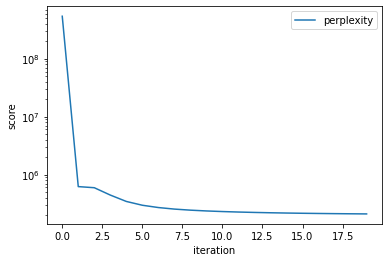

In [5]:
plt.plot(model.score_tracker['perplexity'].value, label = 'perplexity')

plt.legend(loc = 'best')

plt.xlabel('iteration')
plt.ylabel('score')
plt.yscale("log")
plt.show()

In [6]:
X_train_pd = model.transform(bv_train_tag_month)

with open('data/vw_data/y_valid.txt') as f:
    y_valid = f.read().split('\n')

with open('data/vw_data/y_train.txt') as f:
    y_train = f.read().split('\n')

X_train = []
for i in tqdm(range(len(y_train))):
    X_train.append(X_train_pd[i].values)
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)

X_train_np, y_train_np = shuffle(X_train_np, y_train_np,random_state=42)

X_valid_pd = model.transform(bv_test_tag_month)
X_valid = []
for i in tqdm(range(len(y_valid))):
    X_valid.append(X_valid_pd[i].values)
    
X_valid_np = np.array(X_valid)

In [8]:
classifier = XGBClassifier(n_jobs=-1)
classifier.fit(X_train_np[:20000], y_train_np[:20000])
pred = classifier.predict(X_valid_np)
print(classification_report(y_valid, pred, zero_division=1))

[12:17:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

        1999       1.00      0.00      0.00        19
        2000       0.00      0.00      0.00        69
        2001       0.14      0.02      0.04        96
        2002       0.20      0.06      0.10       143
        2003       0.12      0.03      0.05       134
        2004       0.21      0.12      0.15       183
        2005       0.19      0.19      0.19       240
        2006       0.22      0.18      0.20       256
        2007       0.14      0.08      0.10       236
        2008       0.21      0.22      0.21       332
        2009       0.17      0.27      0.21       423
        2010       0.14      0.15      0.14       375
        2011       0.18      0.21      0.19 

**Вывод:** качество несколько ухудшилось по сравнению с предыдущим экспериментом. По всем метрикам наблюдается регресс 2-3%. То есть введение декоррелирующего регуляризатора оказало в целом негативное влияние на результат. 

Отсюда следует гипотеза: увеличивая рареженность матрица $\Phi$, мы уменьшаем разнообразие тематических векторов, то есть каждый из них становится более разреженным. Это может приводить к тому, что классификатор получает на вход вектор с весьма бедной информацией. Для проверки этой гипотезы, попробуем добиться обратного эффекта -- сглаживания.

## 2.5 Text + tag + month, smooth regularizer

In [3]:
dictionary = artm.Dictionary()
dictionary.gather(data_path='data/vw_batches/batches_train_tag_month/')

model = artm.ARTM(num_topics=250,
                  dictionary=dictionary, 
                  class_ids={'@default_class': 1.0, '@tag': 10.0, '@month': 10.0}, num_processors=12)

model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))
model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))
model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'))
model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'))

model.regularizers.add(artm.SmoothSparsePhiRegularizer("smooth_phi", tau=0.1))
model.regularizers.add(artm.SmoothSparseThetaRegularizer("smooth_theta", tau=0.1))


iterator = tqdm(range(20))
for i in iterator:
    model.fit_offline(bv_train_tag_month, num_collection_passes=1)
    iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1], })

model.dump_artm_model("data/model/tag_month_smooth/")

# model = artm.load_artm_model('data/model/tag_month_smooth/')
# model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary), overwrite=True)
# model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10), overwrite=True)
# model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'), overwrite=True)
# model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'), overwrite=True)

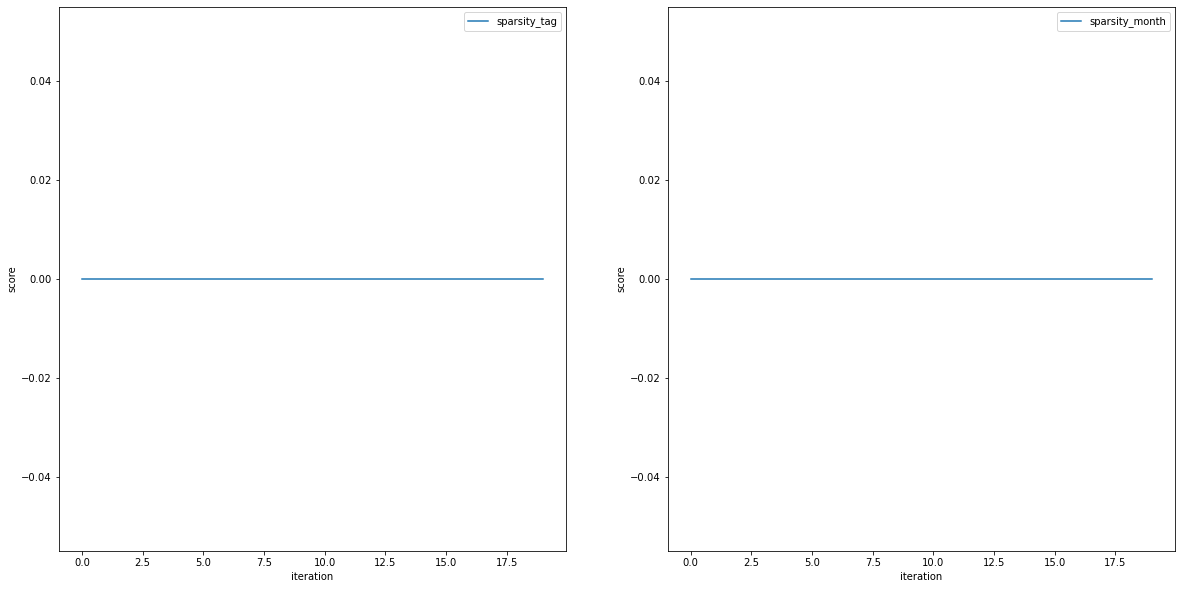

In [4]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(model.score_tracker['sparsity_tag'].value, label = 'sparsity_tag')

plt.legend(loc = 'best')

plt.xlabel('iteration')
plt.ylabel('score')


plt.subplot(1, 2, 2)
plt.plot(model.score_tracker['sparsity_month'].value, label = 'sparsity_month')

plt.legend(loc = 'best')

plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

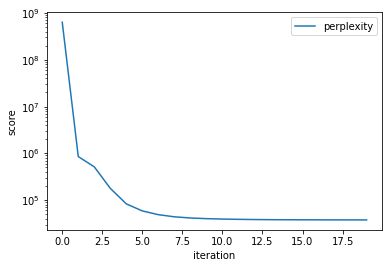

In [5]:
plt.plot(model.score_tracker['perplexity'].value, label = 'perplexity')

plt.legend(loc = 'best')

plt.xlabel('iteration')
plt.ylabel('score')
plt.yscale("log")
plt.show()

In [6]:
X_train_pd = model.transform(bv_train_tag_month)

with open('data/vw_data/y_valid.txt') as f:
    y_valid = f.read().split('\n')

with open('data/vw_data/y_train.txt') as f:
    y_train = f.read().split('\n')

X_train = []
for i in tqdm(range(len(y_train))):
    X_train.append(X_train_pd[i].values)
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)

X_train_np, y_train_np = shuffle(X_train_np, y_train_np,random_state=42)

X_valid_pd = model.transform(bv_test_tag_month)
X_valid = []
for i in tqdm(range(len(y_valid))):
    X_valid.append(X_valid_pd[i].values)
    
X_valid_np = np.array(X_valid)

In [7]:
classifier = XGBClassifier(n_jobs=-1)
classifier.fit(X_train_np[:20000], y_train_np[:20000])
pred = classifier.predict(X_valid_np)
print(classification_report(y_valid, pred, zero_division=1))

/home/serg/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:06:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

        1999       1.00      0.00      0.00        19
        2000       0.00      0.00      0.00        69
        2001       0.20      0.02      0.04        96
        2002       0.15      0.06      0.09       143
        2003       0.14      0.04      0.06       134
        2004       0.25      0.16      0.20       183
        2005       0.21      0.18      0.20       240
        2006       0.16      0.18      0.17       256
        2007       0.13      0.08      0.09       236
        2008       0.17      0.23      0.19       332
        2009       0.23      0.31      0.26       423
        2010       0.16      0.22      0.18       375
        2011       0.28      0.29      0.28 

**Вывод:** гипотеза частично себя оправдала: использование SmoothSparseRegularizer для обеих матриц позволило увеличить немного качество. Все метрики возросли приблизительно на 1%. 

## 2.6 BigARTM as a classifier

In [10]:
dictionary = artm.Dictionary()
dictionary.gather(data_path='data/vw_batches/batches_train_tag_month_year/')

model = artm.ARTM(num_topics=250,
                  dictionary=dictionary, 
                  class_ids={'@default_class': 1.0, '@tag': 10.0, '@month': 10.0, '@year': 10.0}, num_processors=12)

model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))
model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))
model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'))
model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'))
model.scores.add(artm.SparsityPhiScore(name='sparsity_year', class_id='@year'))


model.regularizers.add(artm.SmoothSparsePhiRegularizer("smooth_phi", tau=0.1))
model.regularizers.add(artm.SmoothSparseThetaRegularizer("smooth_theta", tau=0.1))


iterator = tqdm(range(20))
for i in iterator:
    model.fit_offline(bv_train_tag_month_year, num_collection_passes=1)
    iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1], })

model.dump_artm_model("data/model/tag_month_clf/")

# model = artm.load_artm_model('data/model/tag_month_clf/')
# model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary), overwrite=True)
# model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10), overwrite=True)
# model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'), overwrite=True)
# model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'), overwrite=True)

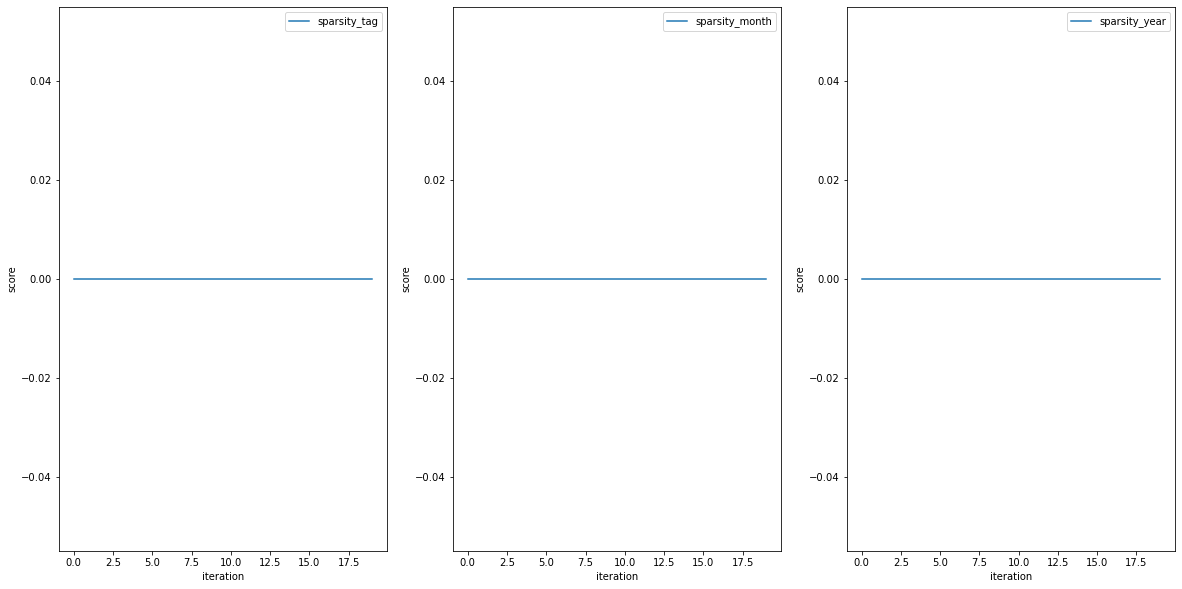

In [12]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.plot(model.score_tracker['sparsity_tag'].value, label = 'sparsity_tag')

plt.legend(loc = 'best')

plt.xlabel('iteration')
plt.ylabel('score')


plt.subplot(1, 3, 2)
plt.plot(model.score_tracker['sparsity_month'].value, label = 'sparsity_month')

plt.legend(loc = 'best')

plt.xlabel('iteration')
plt.ylabel('score')


plt.subplot(1, 3, 3)
plt.plot(model.score_tracker['sparsity_year'].value, label = 'sparsity_year')

plt.legend(loc = 'best')

plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

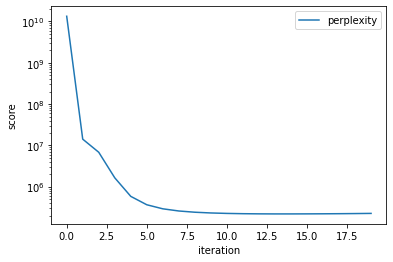

In [13]:
plt.plot(model.score_tracker['perplexity'].value, label = 'perplexity')

plt.legend(loc = 'best')

plt.xlabel('iteration')
plt.ylabel('score')
plt.yscale("log")
plt.show()

In [16]:
p_cd_test = model.transform(batch_vectorizer=bv_test_tag_month_year, predict_class_id="@year")

p_cd_test.shape

(23, 6604)

In [30]:
index = p_cd_test.index
p_cd_test_np = p_cd_test.to_numpy().T
raw_ids = np.argmax(p_cd_test_np, axis=-1)
predicts = [index[idx].split('_')[-1] for idx in raw_ids]

In [32]:
with open('data/vw_data/y_valid.txt') as f:
    y_valid = f.read().split('\n')

In [34]:
print(classification_report(y_valid, predicts))

              precision    recall  f1-score   support

        1999       1.00      0.16      0.27        19
        2000       0.73      0.12      0.20        69
        2001       0.65      0.18      0.28        96
        2002       0.64      0.24      0.35       143
        2003       0.55      0.24      0.33       134
        2004       0.45      0.30      0.36       183
        2005       0.33      0.20      0.25       240
        2006       0.44      0.27      0.34       256
        2007       0.63      0.29      0.40       236
        2008       0.39      0.36      0.37       332
        2009       0.45      0.44      0.45       423
        2010       0.38      0.46      0.42       375
        2011       0.30      0.41      0.35       384
        2012       0.35      0.39      0.37       427
        2013       0.39      0.40      0.39       387
        2014       0.38      0.28      0.32       309
        2015       0.27      0.34      0.30       387
        2016       0.27    

**Вывод:** очевидно, что введение зная год, ответить на вопрос о нем несложно. Видно, что качество модели **существенно** превосходит все предыдущие, однако, не 100%.

Почему так? Тут роль может сыграть то, что мы приближаем исходную матрицу не точно. Более того, параметры использовались как в предыдущей модели, что может быть неоптимально с учетом дополнительной модальности. Однако сам факт того, что модель получилась значительно точнее, чем все предыдущие, говорит о том, модель использует дополнительную модальность для предсказания, и при более тщательном подборе параметров может показывать лучшие метрики.